In [7]:
<small><i>This notebook was created by Franck Iutzeler, Jerome Malick and Yann Vernaz (2016).</i></small>
<!-- Credit (images) Jeffrey Keating Thompson. -->

SyntaxError: invalid syntax (<ipython-input-7-bff6f9912f4a>, line 1)

<center><img src="UGA.png" width="30%" height="30%"></center>
<center><h3>Master of Science in Industrial and Applied Mathematics (MSIAM)</h3></center>
<hr>
<center><h1>Convex and distributed optimization</h1></center>
<center><h2>Part II - Classification (3h + 3h home work)</h2></center>

# Outline

In this Lab, we will investigate some gradient-based and proximal algorithms on the binary classification problems with logistic regression.

# Supervised Classification and Logistic Regression

### Machine Learning as an Optimization problem

We have some *data*  $\mathcal{D}$ consisting of $m$ *examples* $\{d_i\}$; each example consisting of a *feature* vector $a_i\in\mathbb{R}^d$ and an *observation* $b_i\in \mathcal{O}$: $\mathcal{D} = \{[a_i,b_i]\}_{i=1..m}$ .


The goal of *supervised learning* is to construct a predictor for the observations when given feature vectors.


A popular approach is based on *linear models* which are based on finding a *parameter* $x$ such that the real number $\langle a_i , x \rangle$ is used to predict the value of the observation through a *predictor function* $g:\mathbb{R}\to \mathcal{O}$: $g(\langle a_i , x \rangle)$ is the predicted value from $a_i$.


In order to find such a parameter, we use the available data and a *loss* $\ell$ that penalizes the error made between the predicted $g(\langle a_i , x \rangle)$ and observed $b_i$ values. For each example $i$, the corresponding error function for a parameter $x$ is $f_i(x) =   \ell( g(\langle a_i , x \rangle) ; b_i )$. Using the whole data, the parameter that minimizes the total error is the solution of the minimization problem
$$ \min_{x\in\mathbb{R}^d} \frac{1}{m} \sum_{i=1}^m f_i(x) = \frac{1}{m} \sum_{i=1}^m  \ell( g(\langle a_i , x \rangle) ; b_i ). $$


### Binary Classification with Logisitic Regression

In our setup, the observations are binary: $\mathcal{O} = \{-1 , +1 \}$, and the *Logistic loss* is used to form the following optimization problem
\begin{align*}
\min_{x\in\mathbb{R}^d } f(x) := \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ).
\end{align*}

Under some statistical hypotheses, $x^\star = \arg\min f(x)$ maximizes the likelihood of the labels knowing the features vector. Then, for a new point $d$ with features vector $a$, 
$$ p_1(a) = \mathbb{P}[d\in \text{ class }  +1] = \frac{1}{1+\exp(-\langle a;x^\star \rangle)} $$
Thus, from $a$, if $p_1(a)$ is close to $1$, one can decide that $d$ belongs to class $1$; and the opposite decision if $p(a)$ is close to $0$. Between the two, the appreciation is left to the data scientist depending on the application.


# Supervised classification datasets



### Reading the dataset

We will use LibSVM formatted data, meaning that each line of the file (i.e. each example) will have the form

<tt>class feature_number1:feature_value1 feature_number2:feature_value2 ... feature_number$n_i$:feature_value$n_i$ </tt>

You may read such a file using MLUtils's <a href="http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.util.MLUtils.loadLibSVMFile">`loadLibSVMFile`</a> routine on the supervised classification datasets below.

The elements of the produced RDD have the form of <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint">`LabeledPoints`</a> composed of a label `example.label` corresponding to the class (+1 or -1) and a feature vector `example.features` generally encoded as a <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector">`SparseVector`</a>.


In [1]:
# set up spark environment (using Spark local mode set to # cores on your machine)
from pyspark import SparkContext, SparkConf

conf = SparkConf()
conf.setMaster("local[*]")
conf.setAppName("MSIAM part II - Logistic Regression")

sc = SparkContext(conf = conf)

We remind you that you can access this interface (Spark UI) by simply opening http://localhost:4040 in a web browser.

In [2]:
# path to LibSVM Datasets
LibSVMHomeDir="data/LibSVM/"
LibName="ionosphere.txt"             # a small dataset to begin with
#LibName="rcv1_train.binary"          # a bigger one 

__Question 1__
> Form an RDD from the selected dataset.

> Count the number of examples, features, the number of examples of class '+1' and the density of the dataset.

In [3]:
from pyspark.mllib.stat import KernelDensity
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
import os.path

path = os.path.join(LibSVMHomeDir,LibName)
data = MLUtils.loadLibSVMFile(sc,path)

def nbExamples(rdd) :
    return rdd.count()
def nbFeatures(rdd) :
    nbFeatures = rdd.map(lambda line : line.features.size).sum()
    return int(nbFeatures/rdd.count())
def density(rdd) :
    nbFeatures = rdd.map(lambda line : line.features.size).sum()
    nonZeros = data.map(lambda line: line.features.numNonzeros()).sum()
    return nonZeros/nbFeatures

print("Number of examples: ",nbExamples(data))
print("The number of features is : ",nbFeatures(data))
nbClassPlus1Examples = data.map(lambda line: line.label).filter(lambda s : float(s) == 1)
print("The number of examples of class +1 is : ",nbExamples(nbClassPlus1Examples))
print("Density :",density(data))

Number of examples:  351
The number of features is :  34
The number of examples of class +1 is :  225
Density : 0.884112619406737


### Preprocessing

An important first step for learning by regression is to preprocess the dataset. This processing usually consists in:
* Adding an intercept, that is an additional feature equal to one for all examples (statistically, this accounts for the fact that the two classes may be imbalanced).
* For the dense datasets:
    *  normalize to have zero-mean and unit variance for every feature (except the interecept for instance.
* For sparse datasets:
    * normalize so that the feature vector has unit $\ell_2$ norm for each example.

This does not really change the problem but it will ease the convergence of the applied optimization algorithms.

__Question 2__
> Form a new RDD with the scaled version of the dataset.

> Check that the number of examples, features, and the density is correct.

In [ ]:
from pyspark.mllib.feature import Normalizer
from pyspark.mllib.util import *

normalizedData = data.map(lambda line : LabeledPoint(line.label,Normalizer().transform(line.features.toArray())))
scaledNormData = normalizedData.map(lambda line : LabeledPoint(line.label,np.append(line.features.toArray(),1)))

print("Number of examples in the dataset :",nbExamples(data),"\n\
Number of examples in normalized data :",nbExamples(scaledNormData))

print("\nNumber of features in the dataset :",nbFeatures(data),"\n\
Number of features in normalized data :",nbFeatures(scaledNormData))

print("\nDensity of the dataset :",density(data),"\n\
Density of the normalized dataset :",density(scaledNormData))

Number of examples in the dataset : 351 
Number of examples in normalized data : 351


#  Initialization

We will set up here the variables, and the training versus testing dataset. Indeed, we will take a portion of the dataset to learn called the `learning set`, say $95$%, and we will test our predictions on the rest, the `testing set`.

__Question 3__

>  Split the scaled dataset into a training and a testing set. For instance, you may use the function <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit">`randomSplit`</a>.

> Count the number of examples, and subjects in class '+1' in each set.

In [5]:
trainingData, testingData = scaledNormData.randomSplit([95, 5])
print("The number of examples in the dataset : ",nbExamples(scaledNormData))
print("The number of examples in the training dataset : ",nbExamples(trainingData))
print("The number of examples in the testing dataset : ",nbExamples(testingData))

classPlus1Data = scaledNormData.filter(lambda line : line.label == 1)
classPlus1TrainingData = trainingData.filter(lambda line : line.label == 1)
classPlus1TestingData = testingData.filter(lambda line : line.label == 1)
print("\nThe number of examples in class +1 dataset : ",nbExamples(classPlus1Data))
print("The number of examples in class +1 training dataset : ",nbExamples(classPlus1TrainingData))
print("The number of examples in class +1 testing dataset: ",nbExamples(classPlus1TestingData))

The number of examples in the dataset :  351
The number of examples in the training dataset :  335
The number of examples in the testing dataset :  16

The number of examples in class +1 dataset :  225
The number of examples in class +1 training dataset :  215
The number of examples in class +1 testing dataset:  10


#  Minimization of the logistic loss with the Gradient algorithm

The goal of this section is to: 
1. Compute gradients of the loss functions.
2. Implement a Gradient algorithm.
3. Observe the prediction accuracy of the developed methods.

__Question 4__
>Define a routine computing functional loss and gradient from one example 

For a Labeled point <tt>example</tt> (`LabeledPoint(example.label,example.features)`) that we denoted $(b_i,a_i)$ and a regressor <tt>x</tt>, compute $f_i(x) = \log(1+\exp(-b_i \langle a_i,x\rangle) )$ and $\nabla f_i(x)$.


In [6]:
from math import *
from random import *

import numpy as np
def logistic_loss_per_example(example,x):
    """ Computes the logistic loss for a Labeled point
    Args:
        example: a labeled point
        x: regressor
    Returns:
        real value: l 
    """
    f = log(1 + exp(-1 * example.label * np.dot(example.features,x)))

    return f

def randomArray(size) :
    x = np.zeros(size)
    for i in range(1,size) :
        x[i] = uniform(-1,1)
    return x

size = trainingData.first().features.size
testLoss = trainingData.map(lambda line : logistic_loss_per_example(line,randomArray(size)))
print("The logistic loss for the first example is :\n",testLoss.first())

The logistic loss for the first example is :
 0.8877370667180612


In [7]:
import numpy as np
def logistic_grad_per_example(example,x):
    """ Computes the logistic gradient for a Labeled point
    Args:
        example: a labeled point
        x: regressor
    Returns:
        numpy array: g 
    """
    g = (-1 * example.label * example.features)/(1 + exp(example.label * np.dot(example.features,x)))
    return  g

testGradientLoss = trainingData.map(lambda line : logistic_grad_per_example(line,randomArray(size)))
print("The logistic grad for the first example is :\n",testGradientLoss.first())

The logistic grad for the first example is :
 [-0.183255827603,-0.0,-0.182411018238,0.0107919356875,-0.156212765124,-0.00422587938453,-0.152831695104,0.0691021074726,-0.183255827603,-0.00689041911788,-0.156212765124,0.0325370721909,-0.109504519784,0.0823643317162,-0.110935747798,0.0700458749848,-0.154587285933,0.0706304610748,-0.106676882364,0.058993716022,-0.104402677544,0.054379334283,-0.0677056980663,0.086784462278,-0.10410946822,0.0937738395428,-0.0752778288628,0.0846055504878,-0.0389711842981,0.0624719116299,-0.077456740653,0.0998506027861,-0.0341607188235,0.0830148899042,-0.588413908427]


__Question 5__
>Implement a gradient descent algorithm to minimize
\begin{align*}
\min_{x\in\mathbb{R}^d } f(x) := \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ) = \frac{1}{m}  \sum_{i=1}^m f_i(x).
\end{align*}
>by 
* defining a function taking a stepsize and a maximal number of iterations and returning the final point as well as the value of $f(x)$ at each iteration. 
* running `x, f_tab = grad_algo(gamma,MAX_ITE)`


For the choice of the stepsize, we help you by provinding you an upper bound on the Lipschitz constant $L$ of $\nabla f$:

$ L \leq L_b = \max_i 0.25 \|a_i\|_2^2$.

In [8]:
import numpy as np
def compute_gamma1():
    Lb = 0.25 * trainingData.map(lambda line : pow(np.linalg.norm(line.features,2),2)).max()
    return 1/Lb
print("Limite :",compute_gamma1())

Limite : 1.9999999999999991


In [9]:
def grad_algo(gamma, MAX_ITER):
    i = 0
    x = randomArray(size)
    m = trainingData.count()
    f_tab = np.zeros(MAX_ITER)
    while i < MAX_ITER:
        print(i, end=' ')
        f = trainingData.map(lambda line : (1/m) * logistic_grad_per_example(line,x)).sum()
        f_tab[i] = trainingData.map(lambda line : (1/m) * logistic_loss_per_example(line,x)).sum()
        x = x - gamma * f    
        i += 1
    return x, f_tab

MAX_ITER = 20
x, f_tab = grad_algo(0.66,MAX_ITER)
print("\nx =",x,"\nf_tab =",f_tab)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
x = [ 0.31852239 -0.84020755  0.40990302  0.46622965  1.33049156  0.76211473
  0.47927467  0.47254749 -0.33148633  0.15009899  0.28655886 -0.36301839
  0.99311494  0.48330036  0.48150046  1.00231728 -0.68591179  0.80407707
 -0.03415951 -0.69601696  0.43596012  0.78115396 -0.67939819 -0.10906117
 -0.27393773 -0.88115291 -0.45868408  0.63189043  0.14854375 -0.11277849
  0.13221402  0.81450854 -0.39958801 -0.58602353  0.29892361] 
f_tab = [ 0.70674683  0.67591307  0.6546731   0.63941299  0.62788675  0.61871831
  0.6110657   0.60441092  0.5984325   0.59292881  0.58777194  0.58287964
  0.57819825  0.57369211  0.56933701  0.56511606  0.5610171   0.55703102
  0.55315076  0.54937057]


__Question 6__

> Plot the functional value versus the iterations.

> Investigate if the computations are distributed over different threads.

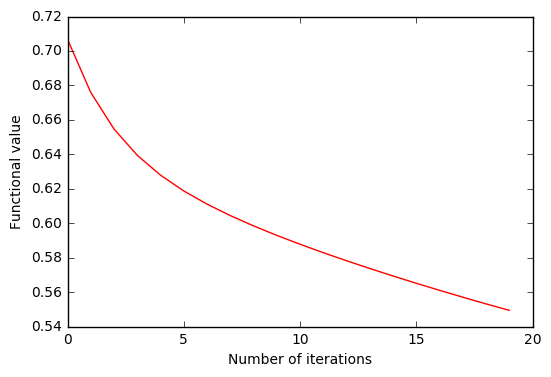

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.plot(range(MAX_ITER), f_tab, color="red", linewidth=1.0, linestyle="-")
plt.xlim(0, MAX_ITER)
plt.xlabel('Number of iterations')
plt.ylabel('Functional value')
plt.show()

# Regularized logisitic regression

In addition to the loss, it is usual to add a regularization term of the form
$$ r(x) = \lambda_1 \|x\|_1 + \lambda_2 \|x\|^2_2 $$

The first part promotes sparsity of the iterates while the second part prevents over-fitting. 
This kind of regularization is often called:
- *elastic-net* when $ \lambda_1$ and $ \lambda_2$ are non-null
- $\ell_1$ when $\lambda_2 = 0$
- *Tikhonov* when $\lambda_1 = 0$

The full optimization problems now writes
\begin{align*}
\min_{x\in\mathbb{R}^d } g(x) =  \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ) +  \lambda_1 \|x\|_1 + \lambda_2 \|x\|^2_2
\end{align*}


__Question 7__

> Which part of $g$ is smooth, which part is not? Write $g$ as 
$$ g(x) =  \frac{1}{m}  \sum_{i=1}^m s_i(x) + n(x)  $$
where the $(s_i)$ are smooth function and $n$ is non smooth.

> ----------------------------------------------------------------------------------------------------------------

>      --> \lambda_1 \|x\|_1 is not differentiable at 0 --> not smooth function

>      The reasons for regularization are 

>       1) to avoid overfitting by not generating high coefficients for predictors that are sparse.  

>       2) to stabilize the estimates especially when there's collinearity in the data.  

> ----------------------------------------------------------------------------------------------------------------

> Define a function `regularized_logistic_grad_per_example(examples,x)` returning the gradient of the smooth part per example (i.e. $\nabla s_i(x)$)

> Define a function `n_prox(x,gamma)` returning the proximal operator of the non-smooth part (i.e. $\mathbf{prox}_{\gamma n}(y)$)

we recall that
$$ \mathbf{prox}_{\gamma n}(y) = \arg\min_x\left\{ n(x) + \frac{1}{2\gamma} \|x-y\|_2^2 \right\} $$

In [12]:
import numpy as np
# Part I
m = trainingData.count()
def regularized_logistic_grad_per_example(examples,x,lambda2):
    return logistic_grad_per_example(examples,x) + 2 * lambda2 * x 

testRegularizedGradientLoss = trainingData.map(lambda line : regularized_logistic_grad_per_example(line,randomArray(size),0.5))
print("The regularized logistic grad for the first example is :\n",testRegularizedGradientLoss.first(),"\n")

# Part II
def n_prox(x,gamma):
    res = np.zeros(size)
    for i in range(1,size):
        if x[i] > gamma :
            res[i] = x[i] - gamma
        elif x[i] < -gamma :
            res[i] = x[i] + gamma
        else :
            res[i] = 0
    return res


The regularized logistic grad for the first example is :
 [-0.100094352119,0.501025676572,0.349667747026,-0.262576761892,-0.576272502764,-0.584230693435,0.316986814719,0.963648399746,0.671456569037,-0.837474160538,0.794358233684,0.098238903952,-0.545132815769,-0.758975553325,0.860890290674,0.477814460214,-0.30559503972,0.39073389562,-0.153084351904,0.671958416213,0.468954208994,-0.928697356101,-0.38901902475,0.196324809962,-0.135452714291,-0.642647972464,-0.462225583427,-0.784269401328,-0.237303713471,0.621891281232,-0.723432128555,0.273117761897,-0.211500567951,0.703702812812,0.0253874996362] 



__Question 8__

> Compute a proximal gradient algorithm for computing a solution of
$$ \min_x  f(x) + r(x) = \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ) + \lambda_1 \|x\|_1 + \lambda_2 \|x\|^2_2 $$


Hint: An admissible stepsize can be found by taking $\gamma = 1/L_{b2}$ with  $ L_b = \max_i 0.25 \|a_i\|_2^2 + 2\lambda_2$.

In [31]:
# Part I
MAX_ITER = 20
def compute_gamma2(lambda2):
    Lb = 0.25 * trainingData.map(lambda line : pow(np.linalg.norm(line.features,2),2)).max() \
        + lambda2 * 2 
    #print(0.5/Lb)
    return 0.5/Lb
print("Gamma value :",compute_gamma2(0.5),"\n")

# Part II
def prox_grad_algo(lambda1,lambda2):
    i = 0
    gamma = compute_gamma2(lambda2)
    x = randomArray(size)
    g_tab = np.zeros(MAX_ITER)
    while i < MAX_ITER:
        print(i, end=' ')
        g = trainingData.map(lambda line : (1/m) * regularized_logistic_grad_per_example(line,x,lambda2)).sum()
        g_tab[i] = trainingData.map(lambda line : (1/m) * logistic_loss_per_example(line,x)).sum() + \
                                    lambda1 * np.linalg.norm(x,1) + lambda2 * pow(np.linalg.norm(x,2),2)
        x = n_prox(x - gamma * g,lambda1*gamma) 
        i += 1
    return x, g_tab

Gamma value : 0.33333333333333326 



__Question 9__

> Examine the behavior and output of your proximal gradient algorithm with different values of $\lambda_1$, $\lambda_2$. What do you observe in terms of sparsity of the solution and convergence rate of the algorithm?

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def compute_min(l1,l2):
    x, g_tab = prox_grad_algo(l1,l2)
    return x, g_tab

MAX_ITER = 50
lamb1 = [0,0,0,0.1]
lamb2 = [0,0.1,0.1,0.1]
x     = [0,0,0,0]
g_tab = [0,0,0,0]
for i in range(0,2):
    x[i], g_tab[i] = compute_min(lamb1[i],lamb2[i])
    print("\n")


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 




Courbe 1 [ red ]
lambda1 = 0 
lambda2 = 0 
gamma = 0.9999999999999996
0.427811108051 



Courbe 2 [ green ]
lambda1 = 0 
lambda2 = 0.1 
gamma = 0.7142857142857141
0.607812643594 




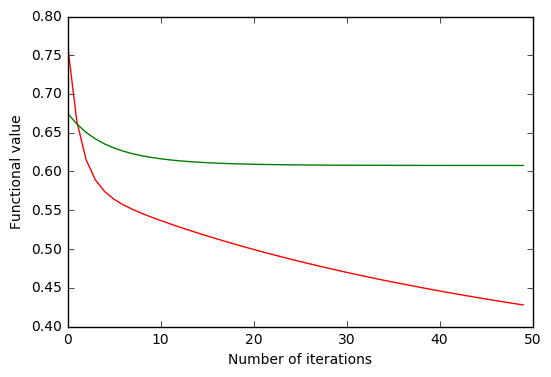

In [29]:
def plot_res(x,g_tab,col):
    plt.plot(range(MAX_ITER), g_tab, col, linewidth=1.0, linestyle="-")

colors = ["red", "green", "blue","black"]
plt.figure()
for i in range(0,2):
    print("\nCourbe", i+1, "[",colors[i],"]\nlambda1 =", lamb1[i], "\nlambda2 =",\
        lamb2[i], "\ngamma =", compute_gamma2(lamb2[i]))
    plot_res(x[i],g_tab[i],colors[i])
    print(g_tab[i][MAX_ITER-1],"\n\n")
plt.xlim(0, MAX_ITER)
plt.xlabel('Number of iterations')
plt.ylabel('Functional value')
plt.show()

__Question 10__

> Write a function that evaluates the accuracy of the classification on the training dataset.

> Investigate how this accuracy change when playing with the regularization terms


In [30]:
# Part 1
training_size = trainingData.count()
def diff_tableau(a,b):
    s = a
    for i in range(0,training_size):
        s[i] = a[i] - b[i]
    return s

#Labelisation
def p(x,example):
      #  label = 0
    p = 1/(1+exp(-1 * np.dot(example.features,x)))
    if p > 0.5:
        label = 1.0
    else:
        label = -1.0
    return label

# test
train = trainingData
def test_train(train,x):
    return train.map(lambda line : p(x,line))

diff = [0,0,0,0]
true_label = train.map(lambda line: line.label)
#print("true_label :\n",true_label.collect())
for i in range(0,2):
    test = test_train(train,x[i])
    diff[i] = diff_tableau(test.collect(),true_label.collect())
    #print("test :",i,"\n",diff_tableau(test.collect(),true_label.collect()),"\n x = \n",x[i],"\n")

# Part 2
def pourcentage_erreur(diff):
    return sum([abs(_i) for _i in diff]) /(2*training_size)

erreur = [0,0,0,0]
for i in range(0,2):
    erreur[i] = pourcentage_erreur(diff[i])
    print("erreur pour x[",i,"] =",erreur[i])

erreur pour x[ 0 ] = 0.14029850746268657
erreur pour x[ 1 ] = 0.35522388059701493


# To go further




### Accelerations

A popular acceleration method to improve the convergence rate of proximal gradient algorithm is the addition of inertia. That is, contructing the next gradient input by a combination of the last two outputs.


In particular, Nesterov's acceleration is the most popular form of inertia. It writes
$$ \left\{ \begin{array}{l}   y_{k+1} = \mathbf{prox\_grad}(x_k) \\ x_{k+1} = y_{k+1} + \alpha_{k+1} (y_{k+1} - y_k)  \end{array} \right. $$ 
with
* $\mathbf{prox\_grad}$ the proximal gradient operation
* $(\alpha_{k})$ the inertial sequence defined as $\alpha_k = \frac{t_k-1}{t_{k+1}}$ and $t_0 = 0$ and $t_{k+1} = \frac{1+\sqrt{1+4t_k^2}}{2}$

__Question 11__

> Implement a fast proximal gradient with this kind of inertia (This algorithm is often nicknamed FISTA).

> Compare the convergence speed with the vanilla proximal gradient algorithm

In [ ]:
def FISTA_prox_grad_algo(lambda1,lambda2):
    
    t_kPlus1 = 1
    
    y_k = randomArray(size)
    y_kPlus1 = randomArray(size)
        
    x = randomArray(size)

    i = 0
    h_tab = np.zeros(MAX_ITER)
    gamma = compute_gamma2(lambda2)
    
    while i < MAX_ITER:
        print(i, end =' ')
        y_kPlus1 = trainingData.map(lambda line : (1/m) * regularized_logistic_grad_per_example(line,x,lambda2)).sum()                            
        h_tab[i] = trainingData.map(lambda line : (1/m) * logistic_loss_per_example(line,x)).sum()
        t_kPlus2 = (1 + sqrt(1 + 4 * t_kPlus1 * t_kPlus1)) / 2
        alpha_kPlus1 = (t_kPlus1 - 1) / t_kPlus2
        x = y_kPlus1 + alpha_kPlus1 * (y_kPlus1 - y_k)
        
        i += 1
        y_k = y_kPlus1
        t_kPlus1 = t_kPlus2
    return x, h_tab
MAX_ITER = 1
x, h_tab = FISTA_prox_grad_algo(0,0)
print("\nx =",x,"\nh_tab =",h_tab)

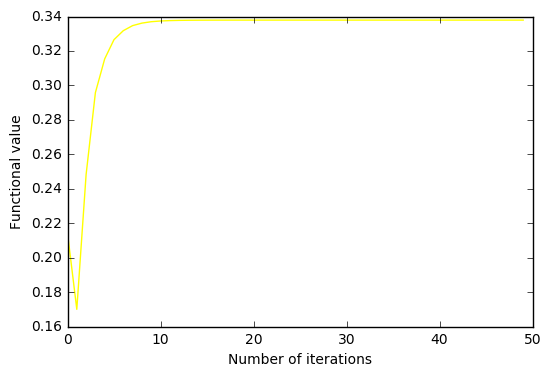

In [23]:
colors = ["red", "green", "blue","black"]
plt.figure()
#for i in range(0,4):
#    print("\nCourbe", i+1, "[",colors[i],"]\nlambda1 =", lamb1[i], "\nlambda2 =",\
#        lamb2[i], "\ngamma =", compute_gamma2(lamb2[i]))
#    plot_res(x[i],g_tab[i],colors[i])
plt.plot(range(MAX_ITER), h_tab, color="yellow", linewidth=1.0, linestyle="-")
plt.xlim(0, MAX_ITER)
plt.xlabel('Number of iterations')
plt.ylabel('Functional value')
plt.show()


### Incremental methods

When dimension increases, incremental algorithms are often priviledged. 

A possible incremental algorithm for a problem such as regularized logistic regression is MISO (see *J Mairal. Incremental Majorization-Minimization Optimization with Application to Large-Scale Machine Learning. SIAM Journal on Optimization,2015 and ICML 2014.*):

* Draw randomly a sample $n$
* Compute $x^n_{k+1} = \mathbf{prox}_{\gamma g} (\bar{x}_k) - \gamma \nabla f_n(\mathbf{prox}_{\gamma g} (\bar{x}_k) )$
* For all $i\neq n$, $x^i_{k+1}=x^i_k$ 
* Compute new $\bar{x}_{k+1} = \frac{1}{m} \sum_{j=1}^m x^j_{k+1}$
 

__Question 12__

> Implement this incremental algorithm and compare with the previous algorithms in terms of convergence time and functional value versus number of passes over the data.